In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.feature_selection import RFE, SequentialFeatureSelector, SelectFromModel
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import RFE, RFECV, VarianceThreshold, SelectFromModel, SequentialFeatureSelector

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from boruta import BorutaPy
from lightgbm import LGBMClassifier
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import loguniform, uniform, randint

sns.set_style('whitegrid')
sns.set_palette('dark')

rs=123

### Data preparation

In [2]:
# loading data

# artificial dataset
art_x_train = pd.read_csv('./data/artificial_train.data', sep=" ", header=None)
art_x_test = pd.read_csv('./data/artificial_valid.data', sep=" ", header=None)
art_y_train = np.array(pd.read_csv('./data/artificial_train.labels', header=None)[0].tolist())

# digits dataset
dig_x_train = pd.read_csv('./data/digits_train.data', sep=" ", header=None)
dig_x_test = pd.read_csv('./data/digits_valid.data', sep=" ", header=None)
dig_y_train = np.array(pd.read_csv('./data/digits_train.labels', header=None)[0].tolist())

In [3]:
# dropping unnecessary NaN columns
art_x_train.drop(columns=art_x_train.columns[-1], axis=1, inplace=True)
art_x_test.drop(columns=art_x_test.columns[-1], axis=1, inplace=True)
dig_x_train.drop(columns=dig_x_train.columns[-1], axis=1, inplace=True)
dig_x_test.drop(columns=dig_x_test.columns[-1], axis=1, inplace=True)

In [4]:
# artificial dataset
art_x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,485,477,537,479,452,471,491,476,475,473,...,477,481,477,485,511,485,481,479,475,496
1,483,458,460,487,587,475,526,479,485,469,...,463,478,487,338,513,486,483,492,510,517
2,487,542,499,468,448,471,442,478,480,477,...,487,481,492,650,506,501,480,489,499,498
3,480,491,510,485,495,472,417,474,502,476,...,491,480,474,572,454,469,475,482,494,461
4,484,502,528,489,466,481,402,478,487,468,...,488,479,452,435,486,508,481,504,495,511


In [5]:
# data size
print('Train: ' , art_x_train.shape)
print('Test: ', art_x_test.shape)

Train:  (2000, 500)
Test:  (600, 500)


-1    1000
 1    1000
dtype: int64


<AxesSubplot:ylabel='count'>

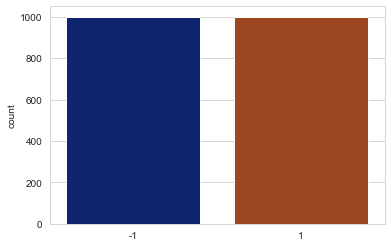

In [6]:
# target distribution
print(pd.Series(art_y_train).value_counts())
sns.countplot(art_y_train)

In [7]:
# digits dataset
dig_x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,550,0,495,0,0,0,0,976,0,0,...,0,0,0,991,991,0,0,0,0,983
1,0,0,0,0,0,0,0,976,0,0,...,0,475,0,991,0,0,991,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,742,0,0,0,0,684,0,956,...,0,0,0,0,0,0,674,0,0,838
4,0,0,0,0,0,0,0,608,0,979,...,991,0,0,828,0,0,0,0,0,0


In [8]:
# data size
print('Train: ' , dig_x_train.shape)
print('Test: ', dig_x_test.shape)

Train:  (6000, 5000)
Test:  (1000, 5000)


 1    3000
-1    3000
dtype: int64


<AxesSubplot:ylabel='count'>

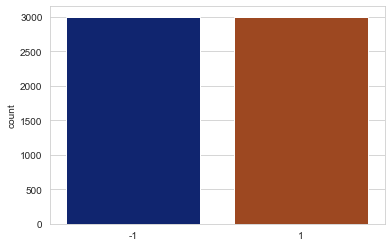

In [9]:
# target distribution
print(pd.Series(dig_y_train).value_counts())
sns.countplot(dig_y_train)

In [10]:
# train-valid split (stratification not needed - target perfectly balanced)
art_x_train, art_x_valid, art_y_train, art_y_valid = train_test_split(art_x_train, art_y_train, test_size=0.33, random_state=42)
dig_x_train, dig_x_valid, dig_y_train, dig_y_valid = train_test_split(dig_x_train, dig_y_train, test_size=0.33, random_state=42)

In [11]:
# crossvalidation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 

In [12]:
# scaling - można spróbować innej metody i porównać
std = StandardScaler()
art_x_train_scaled = std.fit_transform(art_x_train)
art_x_valid_scaled = std.transform(art_x_valid)

std = StandardScaler()
dig_x_train_scaled = std.fit_transform(dig_x_train)
dig_x_valid_scaled = std.transform(dig_x_valid)

### Recursive Feature Elimination (RFE)

In [33]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif  # alternatywnie: f_regression computes ANOVA f-value
k=200
num_features=10

In [34]:
# artificial dataset

In [35]:
selector = SelectKBest(score_func=mutual_info_classif, k=k)

selector.fit(art_x_train_scaled, art_y_train)

SelectKBest(k=200,
            score_func=<function mutual_info_classif at 0x0000025698CD3A60>)

In [36]:
art_x_train_kbest = selector.transform(art_x_train_scaled)

In [37]:
art_x_valid_kbest = selector.transform(art_x_valid_scaled)

In [38]:
clf = RandomForestClassifier()

rfe = RFE(clf, n_features_to_select=num_features)

rfe.fit(art_x_train_kbest, art_y_train)

RFE(estimator=RandomForestClassifier(), n_features_to_select=10)

In [39]:
art_x_train_rfe = rfe.transform(art_x_train_kbest)

In [40]:
art_x_valid_rfe = rfe.transform(art_x_valid_kbest)

In [41]:
rf = RandomForestClassifier()
rf.fit(art_x_train_rfe, art_y_train)

RandomForestClassifier()

In [42]:
balanced_accuracy_score(art_y_valid, rf.predict(art_x_valid_rfe))

0.886405377607993

In [43]:
# digits

In [44]:
k=500
num_features=10

In [45]:
selector = SelectKBest(score_func=mutual_info_classif, k=k)

selector.fit(dig_x_train_scaled, dig_y_train)

SelectKBest(k=500,
            score_func=<function mutual_info_classif at 0x0000025698CD3A60>)

In [46]:
dig_x_train_kbest = selector.transform(dig_x_train_scaled)

In [47]:
dig_x_valid_kbest = selector.transform(dig_x_valid_scaled)

In [48]:
clf = RandomForestClassifier()

rfe = RFE(clf, n_features_to_select=num_features)

rfe.fit(dig_x_train_kbest, dig_y_train)

RFE(estimator=RandomForestClassifier(), n_features_to_select=10)

In [49]:
dig_x_train_rfe = rfe.transform(dig_x_train_kbest)

In [50]:
dig_x_valid_rfe = rfe.transform(dig_x_valid_kbest)

In [51]:
rf = RandomForestClassifier()
rf.fit(dig_x_train_rfe, dig_y_train)

RandomForestClassifier()

In [52]:
balanced_accuracy_score(dig_y_valid, rf.predict(dig_x_valid_rfe))

0.9312678309776375

### Boruta

In [ ]:
# artificial

In [ ]:
rf = RandomForestClassifier(class_weight='balanced', max_depth=5) # z dokumentacji, można się pobawić moze coś zmieni
rf.fit(art_x_train_scaled, art_y_train)

In [ ]:
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
# patrząc na output - zmniejszenie max_iter (default 100) moze powodować wybranie mniejszej ilości zmiennych
# można też podać konkretna liczbe zmiennych która chcemy

# find all relevant features
feat_selector.fit(np.array(art_x_train_scaled), art_y_train)

In [ ]:
# check selected features
feat_selector.support_

In [ ]:
# check ranking of features
feat_selector.ranking_

In [ ]:
art_x_train_boruta = feat_selector.transform(np.array(art_x_train_scaled))
art_x_valid_boruta = feat_selector.transform(np.array(art_x_valid_scaled))

In [ ]:
rf = RandomForestClassifier() # moze próbowac grida zeby polepszyć
rf.fit(art_x_train_boruta, art_y_train)

In [ ]:
balanced_accuracy_score(art_y_valid, rf.predict(art_x_valid_boruta))

In [ ]:
# digital - w pizde długo sie liczy xD na moim lapku niecałe 2h 3 iteracje, na serwerze nie miałam jak odpalic ani na słuzbowym
# moge walczyc po powrocie

In [ ]:
rf = RandomForestClassifier(class_weight='balanced', max_depth=5) # z dokumentacji, można się pobawić moze coś zmieni
rf.fit(dig_x_train_scaled, dig_y_train)

In [ ]:
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
# patrząc na output - zmniejszenie max_iter (default 100) moze powodować wybranie mniejszej ilości zmiennych
# można też podać konkretna liczbe zmiennych która chcemy

# # find all relevant features
feat_selector.fit(np.array(dig_x_train_scaled), dig_y_train)

In [ ]:
dig_x_train_boruta = feat_selector.transform(np.array(dig_x_train_scaled))
dig_x_valid_boruta = feat_selector.transform(np.array(dig_x_valid_scaled))

In [ ]:
rf = RandomForestClassifier()
rf.fit(dig_x_train_boruta, dig_y_train)

In [ ]:
balanced_accuracy_score(dig_y_valid, rf.predict(dig_x_valid_boruta))

### L1

In [ ]:
scores = []
n_of_features = []
cs = np.arange(0.01, 5.01, 0.01)
for c in tqdm(cs):
    selector = SelectFromModel(LinearSVC(C=c, penalty="l1", dual=False, random_state=rs).fit(art_x_train_scaled, art_y_train), prefit=True)
    art_x_train_l1 = selector.transform(art_x_train_scaled)
    art_x_valid_l1 = selector.transform(art_x_valid_scaled)
    estimator = RandomForestClassifier(random_state=rs) 
    estimator.fit(art_x_train_l1, art_y_train)
    y_pred = estimator.predict(art_x_valid_l1)
    n_of_features.append(art_x_train_l1.shape[1])
    scores.append(balanced_accuracy_score(art_y_valid, y_pred))

In [ ]:
plt.figure(figsize=(18,6))
sns.lineplot(x=cs, y=scores) # no słabo to działa xD

In [ ]:
# selecting only best scores for detailed analysis
ids_best = [i for i, elem in enumerate(scores) if elem > 0.68]
scores_best = [round(elem, 5) for i, elem in enumerate(scores) if i in ids_best]
n_of_features_best = [int(elem) for i, elem in enumerate(n_of_features) if i in ids_best]
cs_best = [elem for i, elem in enumerate(cs) if i in ids_best]
best_results = pd.DataFrame([cs_best, n_of_features_best, scores_best], index = ['C', 'No. of features', 'Balanced accuracy']).T
best_results = best_results.sort_values('No. of features').reset_index(drop=True)
best_results.style.background_gradient(cmap="Blues", axis=0) 

In [ ]:
# powtórzyć dla digits

In [ ]:
scores = []
n_of_features = []
cs = np.arange(0.01, 5.01, 0.05)
for c in tqdm(cs):
    selector = SelectFromModel(LinearSVC(C=c, penalty="l1", dual=False, random_state=rs).fit(dig_x_train_scaled, dig_y_train), prefit=True)
    dig_x_train_l1 = selector.transform(dig_x_train_scaled)
    dig_x_valid_l1 = selector.transform(dig_x_valid_scaled)
    estimator = RandomForestClassifier(random_state=rs) 
    estimator.fit(dig_x_train_l1, dig_y_train)
    y_pred = estimator.predict(dig_x_valid_l1)
    n_of_features.append(dig_x_train_l1.shape[1])
    scores.append(balanced_accuracy_score(dig_y_valid, y_pred))

In [ ]:
plt.figure(figsize=(18,6))
sns.lineplot(x=cs, y=scores) # no słabo to działa xD

### RFECV

In [ ]:
# artificial

In [ ]:
rf = RandomForestClassifier(random_state=rs)
rfecv = RFECV(rf, step=1, cv=skf, scoring='balanced_accuracy')
rfecv = rfecv.fit(art_x_train_scaled, art_y_train)

In [ ]:
rfecv.transform(art_x_train_scaled).shape[1] # number of selected features

In [ ]:
y_pred = rfecv.predict(art_x_valid_scaled)
balanced_accuracy_score(art_y_valid, y_pred)

In [ ]:
# digits

In [ ]:
rf = RandomForestClassifier(random_state=rs)
rfecv = RFECV(rf, step=1, cv=skf, scoring='balanced_accuracy')
rfecv = rfecv.fit(dig_x_train_scaled, dig_y_train)

In [ ]:
rfecv.transform(dig_x_train_scaled).shape[1] # number of selected features

In [ ]:
y_pred = rfecv.predict(dig_x_valid_scaled)
balanced_accuracy_score(dig_y_valid, y_pred)

In [ ]:
##### poniżej - jakieś próbowane rzeczy, może się przyda docelowo
# grid search dla svmki 
# grid search dla lgbm

In [ ]:
# SVM 
#model
model = Pipeline([('standardscaler', StandardScaler()), # to do wywalenia jeśli byśmy miały używać bo dane już zeskalowane
                  ('model', SVC())])

grid = [{
    'model__kernel': ['poly', 'sigmoid', 'rbf'],
    'model__C' : [1000, 500, 200, 100, 50, 10, 1.0, 0.1, 0.01],
    'model__gamma' : [1, 0.1, 0.01, 0.001, 0.0001]    
}]

gs = GridSearchCV(model,
                  param_grid=grid, 
                  scoring= 'balanced_accuracy', 
                  refit='balanced_accuracy', 
                  cv=skf, 
                  verbose=2)
gs.fit(art_x_train, art_y_train) # zmiana na _scaled

In [ ]:
gs.best_params_

In [ ]:
model = Pipeline([('standardscaler', StandardScaler()), # taki sam komentarz jak w grid searchu
                  ('model', SVC())])
model.set_params(**gs.best_params_)
model.fit(art_x_train, art_y_train) # _scaled
np.mean(art_y_valid == model.predict(art_x_valid)) # _scaled

In [ ]:
# LGBM
space = dict()
space['num_trees'] = randint(500,1500)
space['num_leaves'] = randint(5,40)
space['learning_rate'] = loguniform(0.01, 1)
space['boosting'] = ['gbdt', 'rf', 'dart', 'goss']
space['tree_learner'] = ['serial', 'feature', 'data', 'voting']

lgbm_clf = LGBMClassifier(objective='binary')

lgbm = RandomizedSearchCV(lgbm_clf,
                    space,
                    scoring='balanced_accuracy',
                    cv=skf,
                    n_iter=100,
                    refit=True,
                    random_state=1,
                    verbose=2)

lgbm.fit(art_x_train_boruta, art_y_train) 
lgbm_clf = LGBMClassifier(objective='binary')
lgbm_clf.set_params(**lgbm.best_params_)
lgbm_clf.fit(art_x_train_boruta, art_y_train)

In [ ]:
balanced_accuracy_score(art_y_valid, lgbm_clf.predict(art_x_valid_boruta))

In [ ]:
# przykład pipeline'a od razu z selekcja
clf = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression())),
  ('classification', RandomForestClassifier())
])
clf.fit(art_x_train, art_y_train)